In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

#LLM

In [2]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="gemma2-9b-it")

#Sates

In [7]:
from pydantic import BaseModel, Field
import uuid
from typing_extensions import List

class Task(BaseModel):
    id: uuid.UUID = Field(default_factory=uuid.uuid4, description="Unique identifier for the task")
    task_name: str = Field(description="Name of the task")
    task_description: str = Field(description="Description of the task")
    estimated_days: int = Field(description="Number of days to complete the task")

class Task_List(BaseModel):
    tasks: List[str] = Field(description="list of all tasks")

class TaskDependency(BaseModel):
    task: Task = Field(description="Task")
    dependent_tasks : List[str] = Field(description="List of dependent tasks")

class TeamMember(BaseModel):
    name: str = Field(description="name of the team member")
    profile: str = Field(description="profile of the team member")

class Team(BaseModel):
    team_members: List[TeamMember] = Field(description="List of all team members")

class TaskAllocation(BaseModel):
    task: Task = Field(description="The allocated task")
    team_member: TeamMember = Field(description="Team member the task is allocated to")

class TaskSchedule(BaseModel):
    task: Task = Field(description="The task to be scheduled")
    start_day: int = Field(description="The starting day of the task")
    end_day: int = Field(description="The ending day of the task")

class DependencyList(BaseModel):
    dependencies: List[TaskDependency] = Field(description="List of all dependencies for a task")

class Schedule(BaseModel):
    schedule: List[TaskSchedule] = Field(description="List of task schedules")

class TaskAllocationList(BaseModel):
    allocation_list: List[TaskAllocation] = Field(description="task allocation list")

class TaskAllocationListIteration(BaseModel):
    """List of task allocations for each iteration"""
    task_allocations_iteration: List[TaskAllocationList] = Field(description="List of task allocations for each iteration")

class ScheduleIteration(BaseModel):
    schedule: List[Schedule] = Field(description="List of task schedules for each iteration")

class Risk(BaseModel):
    task: Task = Field(description="Task")
    score: str = Field(description="Risk associated with the task")

class RiskList(BaseModel):
    risks: List[Risk] = Field(description="List of risks")

class RiskListIteration(BaseModel):
    risks_iteration: List[RiskList] = Field(description="List of risks for each iteration")

#AgentState

In [11]:
from typing_extensions import TypedDict

class AgentState(TypedDict):
    """The project management agent state"""
    project_description: str
    team: Team
    tasks: Task_List
    dependencies: DependencyList
    schedule: Schedule
    task_allocation: TaskAllocationList
    risks: RiskList
    iteration_num: int
    max_iteration: int
    insights: List[str]
    scheduled_iteration: List[Schedule]
    task_allocations_iteration: List[TaskAllocationList]
    risks_iteration: List[RiskListIteration]
    project_risk_score_iteration: List[int]

#Nodes

In [12]:
def task_generation(state: AgentState):
    """Extract task from the given project description"""
    description = state["project_description"]
    prompt = f"""
        You are an expert project manager tasked with analyzing the following project description: {description}
        Your objectives are to: 
        1. **Extract Actionable Tasks:**
            - Identify and list all actionable and realistic tasks necessary to complete the project.
            - Provide an estimated number of days required to complete each task.
        2. **Refine Long-Term Tasks:**
            - For any task estimated to take longer than 5 days, break it down into smaller, independent sub-tasks.
        **Requirements:** - Ensure each task is clearly defined and achievable.
            - Maintain logical sequencing of tasks to facilitate smooth project execution.
    """

    structured_llm =   llm.with_structured_output(Task_List)
    tasks: Task_List = structured_llm.invoke(prompt)
    return {"tasks": tasks}

In [13]:
def task_dependency_node(state: AgentState):
    """Lists the dependencies between the tasks"""
    tasks = state["task"]
    prompt = f"""
        You are a skilled project scheduler responsible for mapping out task dependencies.
        Given the following list of tasks: {tasks}
        Your objectives are to:
            1. **Identify Dependencies:**
                - For each task, determine which other tasks must be completed before it can begin (blocking tasks).
            2. **Map Dependent Tasks:** 
                - For every task, list all tasks that depend on its completion.
    """
    structure_llm = llm.with_structured_output(DependencyList)
    dependencies: DependencyList = structure_llm.invoke(prompt)
    return {"dependencies": dependencies}

In [14]:
def task_schedular_node(state: AgentState):
    """Schedules the tasks based on the dependencies"""
    dependencies = state["dependencies"]
    tasks = state["tasks"]
    insights = state["insights"]
    schedule_iteration = state["scheduled_iteration"]
    prompt = f"""
        You are an experienced project scheduler tasked with creating an optimized project timeline.
        **Given:**
            - **Tasks:** {tasks}
            - **Dependencies:** {dependencies}
            - **Previous Insights:** {insights}
            - **Previous Schedule Iterations (if any):** {schedule_iteration}
        **Your objectives are to: **
            1. **Develop a Task Schedule:**
                - Assign start and end days to each task, ensuring that all dependencies are respected.
                - Optimize the schedule to minimize the overall project duration.
                - If possible parallelize the tasks to reduce the overall project duration.
                - Try not to increase the project duration compared to previous iterations.
            2. **Incorporate Insights:** 
                - Utilize insights from previous iterations to enhance scheduling efficiency and address any identified issues.
    """
    schedule_llm = llm.with_structured_output(Schedule)
    schedule: Schedule = schedule_llm.invoke(prompt)
    state["schedule"] = schedule
    state["schedule_iteration"].append(schedule)
    return state

In [16]:
def task_allocation_node(state: AgentState):
    """Allocates task to team members"""
    tasks = state["tasks"]
    schedule = state["schedule"]
    team = state["team"]
    insights = state["insights"]
    task_allocation_iteration = state["task_allocations_iteration"]
    prompt = f"""
         You are a proficient project manager responsible for allocating tasks to team members efficiently.
         **Given:** 
            - **Tasks:** {tasks} 
            - **Schedule:** {schedule} 
            - **Team Members:** {team} 
            - **Previous Insights:** {insights} 
            - **Previous Task Allocations (if any):** {task_allocation_iteration}

        **Your objectives are to:** 
            1. **Allocate Tasks:** 
                - Assign each task to a team member based on their expertise and current availability. 
                - Ensure that no team member is assigned overlapping tasks during the same time period. 
            2. **Optimize Assignments:** 
                - Utilize insights from previous iterations to improve task allocations. 
                - Balance the workload evenly among team members to enhance productivity and prevent burnout.
                **Constraints:** 
                    - Each team member can handle only one task at a time. 
                    - Assignments should respect the skills and experience of each team member.
    """
    structure_llm = llm.with_structured_output(TaskAllocationList)
    task_allocations: TaskAllocationList = structure_llm.invoke(prompt)
    state["task_allocations"] = task_allocations
    state["task_allocations_iteration"].append(task_allocations)
    return state

In [18]:
def risk_assessment_node(state: AgentState):
    """analyse risk associated with schedule and allocation of task"""
    schedule = state["schedule"]
    task_allocations=state["task_allocations"]
    prompt = f"""
        You are a seasoned project risk analyst tasked with evaluating the risks associated with the current project plan.
        **Given:**
            - **Task Allocations:** {task_allocations}
            - **Schedule:** {schedule}
            - **Previous Risk Assessments (if any):** {state['risks_iteration']}
        **Your objectives are to:**
            1. **Assess Risks:**
                - Analyze each allocated task and its scheduled timeline to identify potential risks.
                - Consider factors such as task complexity, resource availability, and dependency constraints.
            2. **Assign Risk Scores:**
            - Assign a risk score to each task on a scale from 0 (no risk) to 10 (high risk).
            - If a task assignment remains unchanged from a previous iteration (same team member and task), retain the existing risk score to ensure consistency.
            - If the team member has more time between tasks - assign lower risk score for the tasks
            - If the task is assigned to a more senior person - assign lower risk score for the tasks
            3. **Calculate Overall Project Risk:**
            - Sum the individual task risk scores to determine the overall project risk score.
        """
    structure_llm = llm.with_structured_output(RiskList)
    risks: RiskList = structure_llm.invoke(prompt)
    project_task_risk_scores = [int(risk.score) for risk in risks.risks]
    project_risk_score = sum(project_task_risk_scores)
    state["risks"] = risks
    state["project_risk_score"] = project_risk_score
    state["iteration_number"] += 1
    state["project_risk_score_iterations"].append(project_risk_score)
    state["risks_iteration"].append(risks)
    return state

In [19]:
def insight_generation_node(state: AgentState):
    """generate insights from the schedule, task allocation, and risk associated"""
    schedule = state["schedule"]
    task_allocations=state["task_allocations"]
    risks = state["risks"]
    prompt = f"""
        You are an expert project manager responsible for generating actionable insights to enhance the project plan.
        **Given:**
            - **Task Allocations:** {task_allocations}
            - **Schedule:** {schedule}
            - **Risk Analysis:** {risks}
        **Your objectives are to:**
            1. **Generate Critical Insights:**
            - Analyze the current task allocations, schedule, and risk assessments to identify areas for improvement.
            - Highlight any potential bottlenecks, resource conflicts, or high-risk tasks that may jeopardize project success.
            2. **Recommend Enhancements:**
            - Suggest adjustments to task assignments or scheduling to mitigate identified risks.
            - Propose strategies to optimize resource utilization and streamline workflow.
                **Requirements:**
                - Ensure that all recommendations aim to reduce the overall project risk score.
                - Provide clear and actionable suggestions that can be implemented in subsequent iterations.
        """
    insights = llm.invoke(prompt).content
    return {"insights": insights}

In [20]:
from langgraph.graph import END

def router(state: AgentState):
    """route the agent to the appropriate node based on the project description"""
    max_iteration = state["max_iteration"]
    iteration_number = state["iteration_number"]

    if iteration_number < max_iteration:
        if len(state["project_risk_score_iterations"])>1:
            if state["project_risk_score_iterations"][-1] < state["project_risk_score_iterations"][0]:
                return END
            else:
                return "insight_generator"
        else:
            return "insight_generator"
    else:
        return END

#WorkFlow

In [21]:
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(AgentState)

# Add nodes to the workflow
workflow.add_node("task_generation", task_generation)
workflow.add_node("task_dependencies", task_dependency_node)
workflow.add_node("task_scheduler", task_schedular_node)
workflow.add_node("task_allocator", task_allocation_node)
workflow.add_node("risk_assessor", risk_assessment_node)
workflow.add_node("insight_generator", insight_generation_node)

# Add edges to the workflow
workflow.set_entry_point("task_generation")
workflow.add_edge("task_generation", "task_dependencies")
workflow.add_edge("task_dependencies", "task_scheduler")
workflow.add_edge("task_scheduler", "task_allocator")
workflow.add_edge("task_allocator", "risk_assessor")
workflow.add_conditional_edges("risk_assessor", router, ["insight_generator", END])
workflow.add_edge("insight_generator", "task_scheduler")

# Set up memory
memory = MemorySaver()

# Compile the workflow
graph_plan = workflow.compile(checkpointer=memory)

#Graph Image

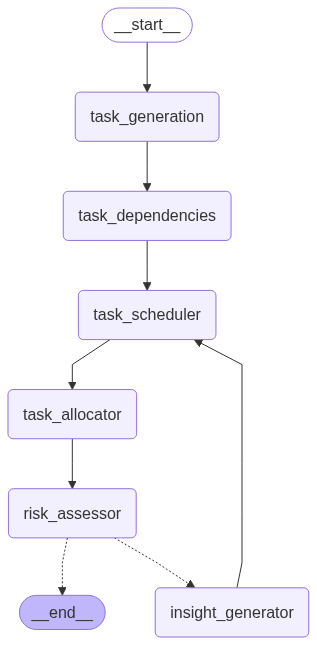

In [22]:
from IPython.display import display, Image
display(Image(graph_plan.get_graph(xray=1).draw_mermaid_png()))

#Inference

In [23]:
import pandas as pd

def get_project_description(file_path:str):
    """Read the project description from the file"""
    with open(file_path, 'r') as file:
            content = file.read()

    return content

def get_team(file_path:str):
    """Read the team members from the CSV file"""
    team_df = pd.read_csv(file_path)
    team_members = [
            TeamMember(name=row['Name'], profile=row['Profile Description'])
            for _, row in team_df.iterrows()
        ]
    team = Team(team_members=team_members)

    return team

In [ ]:
project_description = get_project_description("../data/project_manager_assistant/project_description.txt")
team = get_team("../data/project_manager_assistant/team.csv")

print(project_description)
print(team)

In [ ]:
state_input = {
    "project_description": project_description,
    "team": team,
    "insights": "",
    "iteration_number": 0,
    "max_iteration": 3,
    "schedule_iteration": [],
    "task_allocations_iteration": [],
    "risks_iteration": [],
    "project_risk_score_iterations": []
}

In [ ]:
config = {"configurable": {"thread_id": "1"}}
for event in graph_plan.stream(state_input, config, stream_mode=["updates"]):
    "Print the different nodes as the agent progresses"
    print(f"Current node: {next(iter(event[1]))}")

In [ ]:
final_state = graph_plan.get_state(config).values
print(final_state['iteration_number'])
print(final_state['project_risk_score_iterations'])

#Vizualisation

In [ ]:
# Visalize Project timeline
number_of_iterations = final_state['iteration_number']

for i in range(number_of_iterations):
    ## Tasks schedule
    task_schedules = final_state['schedule_iteration'][i].schedule

    t = []
    # Iterate over the task_schedules and append each task's data to the DataFrame
    for task_schedule in task_schedules:
        t.append([
            task_schedule.task.task_name,
            task_schedule.start_day,
            task_schedule.end_day
        ])

    df_schedule = pd.DataFrame(t,columns=['task_name', 'start', 'end'])

    ## Tasks allocation
    task_allocations = final_state['task_allocations_iteration'][i].task_allocations

    t = []
    # Iterate over the task_schedules and append each task's data to the DataFrame
    for task_allocation in task_allocations:
        t.append([
            task_allocation.task.task_name,
            task_allocation.team_member.name
        ])

    df_allocation = pd.DataFrame(t,columns=['task_name', 'team_member'])

    df = df_allocation.merge(df_schedule, on='task_name')

    import plotly.express as px

    from datetime import datetime, timedelta
    # Get the current date
    current_date = datetime.today()

    # Convert start and end offsets to actual dates
    df['start'] = df['start'].apply(lambda x: current_date + timedelta(days=x))
    df['end'] = df['end'].apply(lambda x: current_date + timedelta(days=x))

    df.rename(columns={'team_member': 'Team Member'}, inplace=True)
    df.sort_values(by='Team Member', inplace=True)
    # Create a Gantt chart
    fig = px.timeline(df, x_start="start", x_end="end", y="task_name", color="Team Member", title=f"Gantt Chart - Iteration:{i+1} ")

    # Update layout for better visualization
    fig.update_layout(
        xaxis_title="Timeline",
        yaxis_title="Tasks",
        yaxis=dict(autorange="reversed"),  # Reverse the y-axis to have tasks in the vertical side
        title_x=0.5
    )

    # Show the plot
    fig.show()